In [1]:
import os
import sys
import random
import exifread
import piexif
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import re

%matplotlib inline

import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from imp import reload
import classparse; reload(classparse)

import exiftool

### Adjust to whatever your class labels are. Alternatively, import them in. 

In [2]:
!pwd

/home/ubuntu/git/deeplearningcourse/elizabeth/data


In [2]:
'''
CLASS_LABELS = {
    'none': (0, 'Background'),
    'flower pot': (1, 'Container'),
    'container': (2, 'Container'),
    'porch': (3, 'Cover'),
    'toy': (4, 'Toy'),
    'bucket': (5, 'Container'),
    'basketball': (6, 'Toy'),
    'car': (7, 'Vehicle'),
    'tarp': (8, 'Cover'),
    'gutter': (9, 'Container'),
    'albo property': (10, 'Presence'),
    'no albo property': (11, 'Presence'),
    'trash bin': (12, 'Container'),
    'pot': (13, 'Container'),
    'tarp': (14, 'Container'),
    'table': (15, 'Other'),
    'umbrella': (16, 'Cover'),
    'car': (17, 'Other'),
    'air conditioner': (18, 'Container'),
    'flower bed': (19, 'Other'),
    'drain': (20, 'Other')
}
'''
annopath = '/home/ubuntu/git/deeplearningcourse/elizabeth/data/harrisonweek2/annotations/'
preprocess = classparse.XML_preprocessor(annopath)
CLASS_LABELS = preprocess.classes

In [3]:
annopath = '/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/annotations/'
photopath = '/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/images/'
os.chdir(annopath)
!pwd

/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/annotations


## definitions key for functionality

In [4]:
def deg_rad(inp,key='deg2rad'):
    '''
        Converts degrees to radian or vice versa
        Inp = # to change
        Indicate with key = {deg2rad, rad2deg}
        
        Returns # in radian or degrees, depending on what you specified
        
    '''
    if key=='deg2rad':
        rad = inp*np.pi/180
        return rad
    
    elif key=='rad2deg':
        deg = inp*180/np.pi
        return deg

def len_at_lat(lat):
    
    '''
        Lat = latitude where info is desired
        
        Returns the length in meters of one degree, latitude or longitude, at a specified latitude
        Also returns conversion rate from degrees to meters
        
    '''
    phi = lat
    
    #length of 1 degree in meters at a specified latitude
    m_per_lat = 111132.92-559.82*np.cos(2*phi) +1.175*np.cos(4*phi) -0.0023*np.cos(6*phi)
    m_per_lon = 111412.84*np.cos(phi) -93.5*np.cos(3*phi) -0.118*np.cos(5*phi)
    
    #number of seconds per meter
    lat_per_m = 1/m_per_lat
    lon_per_m = 1/m_per_lon
    
    return m_per_lat, m_per_lon, lat_per_m, lon_per_m

def dms2dec(inp):
    
    '''
        Converts inp from degrees, minutes, seconds to decimal
        Expects input to be type Ratio
        Returns converted input
    '''
    
    inp = [float(i.num)/float(i.den) for i in inp]
    inp = inp[0] + (inp[1])/60 + inp[2]/3600
    
    return inp

## Gets a count of each of the instances of the classes, total and # of photos, in tagged photos

In [5]:
#COUNT = {key:[0,0] for key in CLASS_LABELS.keys()}
COUNT = {key:0 for key in CLASS_LABELS}
NEW = {}

def get_counts_of_classes(directory, shape=[512,512]):

    ''' This gets the counts of all the classes in a batch of xml files.
    
        -- Input -- (VOC XML files)
        Directory: directory where annotations (.xml) files are stored.
        Shape: desired shape of photos; WEIRDOS will tell you if it's not that shape.

        -- Returns -- (Dicts)
            1. count (shows labels that you have specified & # of appearances)
            2. new (shows labels that you did not specify & # of appearances)
            3. weirdos (returns dimensions of photographs if they don't meet your size)

    '''

    for r, dirs, files in os.walk(directory):
        print(len(files))
        WEIRDOS = {(file[0:-4]+'.JPG'):[0,0] for file in files}

        for f in files:
            #print(f[0:-4])
            # Read the XML annotation file.
            path = os.path.join(directory,f)
            tree = ET.parse(path)
            root = tree.getroot()
            
            f = f[0:-4]+'.JPG'

            shape_tree = root.find('size')
            if int(shape_tree.find('width').text) != shape[0]:
                WEIRDOS[f][0] = shape_tree.find('width').text
            elif int(shape_tree.find('height').text) != shape[1]:
                WEIRDOS[f][1] = shape_tree.find('height').text
            else:
                WEIRDOS.pop(f)
            
            for obj in root.findall('object'):
                label = obj.find('name').text
                
                #if label in CLASS_LABELS.keys():
                if label in CLASS_LABELS:
                    COUNT[label] += 1
                elif label == 'garbage bin':
                    COUNT['trash bin'] +=1
                else:
                    if label not in NEW:
                        NEW[label] = 1
                    else:
                        NEW[label] += 1
    
    return COUNT, NEW, WEIRDOS

In [6]:
count, new, weirdos = get_counts_of_classes(annopath)


1080


In [7]:
in_list = 0
out_list = 0
in_list = sum(count.values())
out_list = sum(new.values())

#print(in_list+out_list)
for key, values in count.items():
    count[key]=values#/in_list
    
count

{'air conditioner': 40,
 'background': 0,
 'basketball': 38,
 'bird bath': 6,
 'car': 120,
 'clutter': 29,
 'container': 581,
 'drain': 9,
 'flower pot': 290,
 'gutter': 42,
 'kayak': 14,
 'ladder': 15,
 'larvae': 15,
 'no larvae': 51,
 'porch': 109,
 'pot': 44,
 'recycling bin': 8,
 'stone feature': 8,
 'table': 81,
 'tarp': 32,
 'toy': 138,
 'trash': 22,
 'trash bin': 182,
 'umbrella': 42,
 'watering can': 9}

## Histogram of classes

In [9]:
import seaborn as sns
plt.style.use('seaborn')
colors = plt.cm.gray(np.linspace(0, .8, len(count.keys()))).tolist()
#colors = sns.color_palette("viridis", n_colors=len(count.keys()), desat=.3)
random.shuffle(colors)

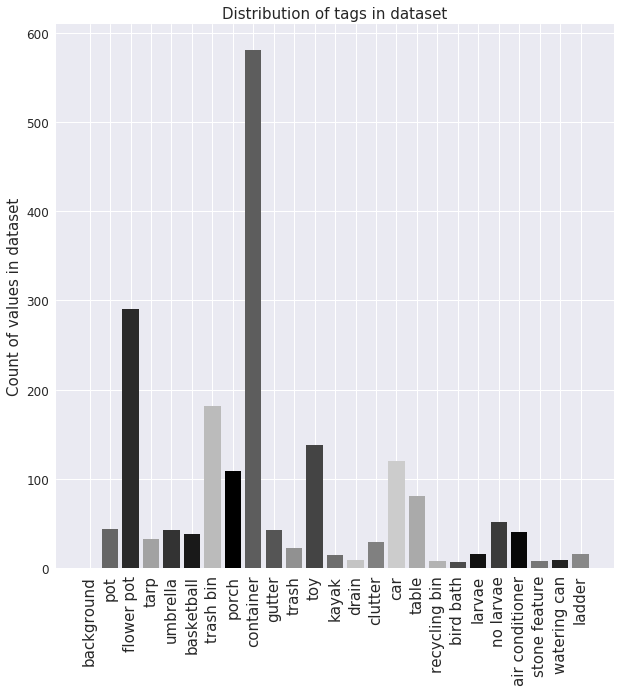

In [10]:
plt.figure(figsize=(10,10))
plt.bar(np.linspace(0,len(count.keys())-1,25),count.values(),color=colors)
plt.xticks(np.linspace(0,len(count.keys())-1,25),list(count.keys()),rotation=90,fontsize=15)
plt.yticks(fontsize=12)
plt.ylabel("Count of values in dataset",fontsize=15)
plt.title("Distribution of tags in dataset",fontsize=15)

## Creates panda dataframe of lat/lon info from GPS file

In [69]:
%reset_selective pd1

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [10]:
os.chdir(photopath)

In [12]:

#photos = pd.read_csv('../../../../../../Downloads/compare.csv',index_col=[0],header=None,names=['photos'])
#files = photos.index.values

for r, dirs, files in os.walk(photopath):
    flist = files
type(np.asarray(flist))

df = pd.DataFrame(index=flist,columns=['lat','lon','alt','date_taken'])
df = df.sort_index()


### Original

In [11]:
#make input either a directory or a pandas table 

def get_gps_from_exif(directory, columns=['lat','lon','date_taken','heading','length','width']):
    
    '''
    Input
    ------
        Directory: (string)
                    path to where photos are stored 
        Columns: (list)
                    columns you want in your pandas table
                    
    Return
    ------
        Pandas DataFrame indexed by photograph
    '''
    for r, dirs, files in os.walk(photopath):  

        df = pd.DataFrame(index=files,columns=columns)
        
        df = df.sort_index()

        for j in files:
            #print(j)
            if j.endswith('.JPG'):
                f = open(j, 'rb')

                # Return Exif tags
                tags = exifread.process_file(f)

                #extracts lat/lon/date/alt (if present) data 
                lat = tags['GPS GPSLatitude'].values
                lon = tags['GPS GPSLongitude'].values
                
                print(j,lon)
                
                length = tags['EXIF ExifImageLength'].values[0]
                width = tags['EXIF ExifImageWidth'].values[0]
                
                try:
                    date = tags['Image DateTime'].values
                except KeyError:
                    date = 'NaN'
                
                if date == 'NaN':
                    try:
                        date = tags['GPS GPSDate'].values
                    except KeyError:
                        date = 'NaN'

                try:
                    alt = tags['GPS GPSAltitude'].values
                    alt = float(alt[0].num)/float(alt[0].den)
                except KeyError:
                    alt = 'NaN'

                #turns lat/lon deg, minute, second into decimal values
                lat = dms2dec(lat)
                lon = dms2dec(lon)

                #adds to dataframe
                df.loc[(j,'lat')]=lat
                df.loc[(j,'lon')] = -lon
                df.loc[(j,'date_taken')] = date
                df.loc[(j,'alt')] = alt
                df.loc[(j,'length')] = length
                df.loc[(j,'width')] = width
                if j.startswith('DJI'):
                    head = !exiftool $j -s -S -Yaw 
                    alt = !exiftool $j -s -S -RelativeAltitude 
                    #print(head,alt)
                    df.loc[(j,'alt')] = float(alt[0])
                    if float(head.l[0]) < 0:
                        df.loc[(j,'heading')] = 360+ float(head.l[0])
                    else:
                        df.loc[(j,'heading')] = float(head.l[0])

        return df

In [115]:
j = 'G0013831_1.JPG'

f = open(j, 'rb')

# Return Exif tags
tags = exifread.process_file(f)

dms2dec(tags['GPS GPSLongitude'].values)

73.73162469997223

In [12]:
photos = get_gps_from_exif(photopath, columns=['lat','lon','date_taken','heading','length','width'])

^C


IndexError: list index out of range

In [116]:
photos.tail()

,lat,lon,date_taken,heading,length,width,alt
G0036554_10.JPG,40.967111,-73.732399,2017:08:03 12:24:15,NaN,3000,4000,52.907
G0036557_2.JPG,40.967211,-73.732082,2017:08:03 12:24:21,NaN,3000,4000,51.421
G0036558_1.JPG,40.967244,-73.731971,2017:08:03 12:24:23,NaN,3000,4000,52.299
G0036561_2.JPG,40.967374,-73.731638,2017:08:03 12:24:29,NaN,3000,4000,49.858
G0036562_4.JPG,40.967416,-73.731525,2017:08:03 12:24:31,NaN,3000,4000,48.195


In [20]:
photos.to_csv('/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/photo_weeks123_GPS_SHAPE.csv')

In [13]:
#photos = pd.DataFrame.from_csv('/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/photo_weeks123_GPS_SHAPE.csv')

## Read in addresses from csv

In [95]:
photos = pd.read_csv('~/Downloads/photo_GPS_with_headings.csv',index_col=[0])
addresses = pd.read_csv('/Users/elizabeth/Box Sync/deeplearningcourse/elizabeth/data/addresses_lat_lon_wks23.csv')

FileNotFoundError: File b'../../../../../../Downloads/photo_GPS_with_headings.csv' does not exist

In [118]:
def find_nearest_gps(pd1,pd2,
                     pd1_lat='lat',pd1_lon='lon',
                     pd2_lat='Latitude',pd2_lon='Longitude',pd2_add='Formatted address'):

    '''Functionality is not broad. Works for specific instance where you have two pandas data frames:
    
        takes:
        
        pd1 = DataFrame indexed by photo name with pd1_lat, pd1_lon columns
        pd2 = DataFrame that includes address, lat, lon as specified in assignment
    '''
    
    for f in pd1.index.values:
        top = pd2.loc[((pd2[pd2_lat]-pd1.loc[f,pd1_lat])**2+
                              (pd2[pd2_lon]-pd1.loc[f,pd1_lon])**2).argsort()[:1]]

        pd1.loc[(f,'nearest_address')] = top[pd2_add].values[0]
        pd1.loc[(f,'add_lat')] = top[pd2_lat].values[0]
        pd1.loc[(f,'add_lon')] = top[pd2_lon].values[0]
        
    
    return pd1

In [723]:
nearest_address = find_nearest_gps(photos, addresses)

## CHANGE LAT/LON IN PD TABLE AND APPEND

In [97]:
!pwd
os.mkdir('nov24_allcontainers')

/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/images


In [704]:
heading_test = pd.read_csv('../../../../../../Downloads/photo_GPS_with_headings.csv',index_col=[0])

In [21]:
#px500 = 5.6 #m/500 pixels
#m_per_px = 5.6/500
m_per_px = 6.77/270.2
m_per_500px = m_per_px*500. #meters per 500 pixels
arcsec_per_px = 0.22/270
arcsec_per_500px = arcsec_per_px*500

#photo & splicing info
w = 3000
h = 2000

#how many times thigns should be done.. working on making this a generalizable function
stepw = len(range(0,w,crop))
steph = len(range(0,h,crop))

stepw

6

In [117]:
pd1 = pd.DataFrame(photos,copy=True)
pd1.tail()

,lat,lon,date_taken,heading,length,width,alt
G0036554_10.JPG,40.967111,-73.732399,2017:08:03 12:24:15,NaN,3000,4000,52.907
G0036557_2.JPG,40.967211,-73.732082,2017:08:03 12:24:21,NaN,3000,4000,51.421
G0036558_1.JPG,40.967244,-73.731971,2017:08:03 12:24:23,NaN,3000,4000,52.299
G0036561_2.JPG,40.967374,-73.731638,2017:08:03 12:24:29,NaN,3000,4000,49.858
G0036562_4.JPG,40.967416,-73.731525,2017:08:03 12:24:31,NaN,3000,4000,48.195


In [23]:
#pd1 = nearest_address[np.isfinite(heading_test.heading)].copy()

#splices crop slice number from file name

for i in pd1.index.values:
    
    lat = pd1.loc[i,'lat']
    lon = pd1.loc[i,'lon']
    theta = pd1.loc[i,'heading']*np.pi/180
    
    if i.startswith('DJI'):
        h = 3000
        w = 4000
    else:
        h = 2000
        w = 3000
    
    crop = 500    
    stepw = len(range(0,w,crop))
    steph = len(range(0,h,crop))
    
    #conversions between meters per degree and degrees per meter
    m_per_lat, m_per_lon, lat_per_m, lon_per_m = len_at_lat(lat)
    
    #lat change equivalent depending on ground sampling distance of photo 
    #note -- explain how you got px500
    lat_step = m_per_500px*lat_per_m #lat step per 500 px
    
    lon_step = m_per_500px*lon_per_m #lon step per 500 px
    
    #accuracy (or precision?) is the difference between theses two
    #print(lat_step, arcsec_per_500px/3600)

    #rotaion matrix [x';y'] = [cos -sin; sin cos][x;y]
    del_lon= lat_step*np.cos(theta) - lon_step*np.sin(theta) 
    del_lat = lat_step*np.sin(theta) +lon_step*np.cos(theta)
    
    #returns number appended to photo, which tells where it was in the mogrify crop/splice functio
    
    c = int(re.sub("[^0-9]","",i[-6:]))
    
    #changes lat lon to upper right hand corner of slice for convenience when working with object pixel locations
    if c in [stepw*0, stepw*1, stepw*2, stepw*3,stepw*4,stepw*5]:
        new_lon = lon - (stepw/2)*del_lon

    elif c in [stepw*0+1, stepw*1+1, stepw*2+1, stepw*3+1, stepw*4+1, stepw*5+1]:
        new_lon = lon - (stepw/2-1)*del_lon

    elif c in [stepw*0+2, stepw*1+2, stepw*2+2, stepw*3+2, stepw*4+2, stepw*5+2]:
        new_lon = lon - (stepw/2-2)*del_lon
        
    elif c in [stepw*0+3,stepw*1+3,stepw*2+3, stepw*3+3, stepw*4+3, stepw*5+3]:
        new_lon = lon - (stepw/2-3)*del_lon
        
    elif c in [stepw*0+4,stepw*1+4,stepw*2+4, stepw*3+4, stepw*4+4, stepw*5+4]:
        new_lon = lon - (stepw/2-4)*del_lon

    elif c in [stepw*0+5,stepw*1+5,stepw*2+5, stepw*3+5, stepw*4+5, stepw*5+5]:
        new_lon = lon - (stepw/2-5)*del_lon
        
    elif c in [stepw*0+6,stepw*1+6,stepw*2+6, stepw*3+6, stepw*4+6, stepw*5+6]:
        new_lon = lon - (stepw/2-4)*del_lon

    elif c in [stepw*0+7,stepw*1+7,stepw*2+7, stepw*3+7, stepw*4+7, stepw*5+7]:
        new_lon = lon - (stepw/2-5)*del_lon

    else:
        print('lon num not defined', c)
        new_lon=lon

    #latitude
    if c in range(0,1*stepw):
        new_lat = lat + (steph/2)*lat_step
        
    elif c in range(1*stepw,2*stepw):
        new_lat = lat + (steph/2-1)*lat_step

    elif c in range(2*stepw,3*stepw):
        new_lat = lat + (steph/2-2)*lat_step

    elif c in range(3*stepw,4*stepw):
        new_lat = lat + (steph/2-3)*lat_step
    
    elif c in range(4*stepw,5*stepw):
        new_lat = lat + (steph/2-4)*lat_step
        
    elif c in range(5*stepw,6*stepw):
        new_lat = lat + (steph/2-5)*lat_step

    else:
        print('lat num not defined', c)
        new_lat=lat
    print(i,new_lon, c)
    pd1.loc[(i,'new_lat')] = new_lat
    pd1.loc[(i,'new_lon')] = new_lon


DJI_0001_18.JPG -73.7322362815 18
DJI_0001_23.JPG -73.7325645259 23
DJI_0001_25.JPG -73.7321268667 25
DJI_0001_34.JPG -73.7322362815 34
DJI_0001_42.JPG -73.7322362815 42
DJI_0003_0.JPG -73.732187184 0
DJI_0003_10.JPG -73.7324080504 10
DJI_0003_43.JPG -73.7325184835 43
DJI_0004_10.JPG -73.7325925093 10
DJI_0004_25.JPG -73.7324738612 25
DJI_0005_25.JPG -73.7324742224 25
DJI_0007_14.JPG -73.7331516667 14
DJI_0007_21.JPG -73.7332712509 21
DJI_0007_23.JPG -73.7332712509 23
DJI_0007_3.JPG -73.7330320824 3
DJI_0007_40.JPG -73.7326733297 40
DJI_0007_41.JPG -73.7327929139 41
DJI_0007_6.JPG -73.7331516667 6
DJI_0007_9.JPG -73.7327929139 9
DJI_0008_17.JPG -73.7329073775 17
DJI_0008_45.JPG -73.7333789482 45
DJI_0009_0.JPG -73.7329450835 0
DJI_0009_1.JPG -73.7330641043 1
DJI_0009_10.JPG -73.7331831251 10
DJI_0009_12.JPG -73.7334211667 12
DJI_0009_17.JPG -73.7330641043 17
DJI_0009_18.JPG -73.7331831251 18
DJI_0009_2.JPG -73.7331831251 2
DJI_0009_28.JPG -73.7334211667 28
DJI_0009_8.JPG -73.7329450835

DJI_0248_4.JPG -73.7342205278 4
DJI_0248_6.JPG -73.7342205278 6
DJI_0292_12.JPG -73.7322106944 12
DJI_0292_13.JPG -73.7323287788 13
DJI_0292_30.JPG -73.7322106944 30
DJI_0293_26.JPG -73.7322747251 26
DJI_0293_30.JPG -73.73250975 30
DJI_0293_31.JPG -73.7326272624 31
DJI_0294_18.JPG -73.7324892202 18
DJI_0294_2.JPG -73.7324892202 2
DJI_0294_26.JPG -73.7324892202 26
DJI_0294_31.JPG -73.7328445982 31
DJI_0294_44.JPG -73.7327261389 44
DJI_0297_10.JPG -73.7326341296 10
DJI_0297_23.JPG -73.7329352269 23
DJI_0297_26.JPG -73.7326341296 26
DJI_0297_38.JPG -73.7328348611 38
DJI_0297_43.JPG -73.7327344954 43
DJI_0297_8.JPG -73.7324333981 8
DJI_0298_0.JPG -73.7324057777 0
DJI_0299_17.JPG -73.7324208926 17
DJI_0299_18.JPG -73.7325106784 18
DJI_0299_43.JPG -73.7326004642 43
DJI_0299_9.JPG -73.7324208926 9
DJI_0300_10.JPG -73.7324678906 10
DJI_0300_2.JPG -73.7324678906 2
DJI_0300_41.JPG -73.7323764887 41
DJI_0300_42.JPG -73.7324678906 42
DJI_0302_13.JPG -73.7327174615 13
DJI_0304_18.JPG -73.7323696395

G0024055_6.JPG nan 6
G0024056_14.JPG nan 14
G0024056_15.JPG nan 15
G0024056_16.JPG nan 16
G0024056_17.JPG nan 17
G0024056_8.JPG nan 8
G0024056_9.JPG nan 9
G0024057_0.JPG nan 0
G0024057_10.JPG nan 10
G0024057_12.JPG nan 12
G0024057_13.JPG nan 13
G0024057_14.JPG nan 14
G0024057_15.JPG nan 15
G0024057_16.JPG nan 16
G0024057_17.JPG nan 17
G0024057_5.JPG nan 5
G0024057_6.JPG nan 6
G0024057_8.JPG nan 8
G0024057_9.JPG nan 9
G0024058_10.JPG nan 10
G0024058_12.JPG nan 12
G0024058_15.JPG nan 15
G0024058_21.JPG nan 21
G0024058_3.JPG nan 3
G0024058_6.JPG nan 6
G0024058_7.JPG nan 7
G0024058_8.JPG nan 8
G0024058_9.JPG nan 9
G0024059_1.JPG nan 1
G0024059_10.JPG nan 10
G0024059_11.JPG nan 11
G0024059_16.JPG nan 16
G0024059_17.JPG nan 17
G0024059_19.JPG nan 19
G0024059_22.JPG nan 22
G0024059_23.JPG nan 23
G0024059_3.JPG nan 3
G0024059_4.JPG nan 4
G0024059_6.JPG nan 6
G0024060_1.JPG nan 1
G0024060_10.JPG nan 10
G0024060_13.JPG nan 13
G0024060_14.JPG nan 14
G0024060_15.JPG nan 15
G0024060_18.JPG nan 18
G

In [27]:
#removes .JPG from name
#pd1.reset_index(inplace=True)
pd1['index']=pd1['index'].str.split('.').str.get(0)
#pd1.sort_index().head()
pd1.set_index(keys='index',inplace=True)
pd1.head()


,lat,lon,date_taken,heading,length,width,alt,new_lat,new_lon
index,,,,,,,,,
DJI_0001_18,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.967170,-73.732236
DJI_0001_23,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.967170,-73.732565
DJI_0001_25,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.967057,-73.732127
DJI_0001_34,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.966944,-73.732236
DJI_0001_42,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.966830,-73.732236


## import px locations of objects

In [28]:
nn_obj = pd.read_csv('/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/nn_above_05_weeks123_batchsize1_nov16.csv',index_col=0)

In [29]:
nn_obj.head()

,classes,class instances,midx,midy,xmin,ymin,xmax,ymax,confidence
photos,,,,,,,,,
G0024071_22,pot,1,438.5,394.0,424,378,453,410,0.089923
G0024071_22,pot,2,450.5,389.0,436,370,465,408,0.056822
G0024071_22,flower pot,1,499.5,498.0,487,484,512,512,0.089264
G0024071_22,flower pot,2,440.0,388.0,426,370,454,406,0.071040
G0024071_22,tarp,1,456.5,435.5,405,364,508,507,0.094373


In [30]:
headings_w_nn = nn_obj.join(pd1,how='outer')
headings_w_nn.head()
#headings_w_nn = headings_w_nn.dropna()
#headings_w_nn.index.values[0][0]

,classes,class instances,midx,midy,xmin,ymin,xmax,ymax,confidence,lat,lon,date_taken,heading,length,width,alt,new_lat,new_lon
DJI_0001_18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.967170,-73.732236
DJI_0001_23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.967170,-73.732565
DJI_0001_25,pot,1.0,141.5,182.5,125.0,163.0,158.0,202.0,0.076133,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.967057,-73.732127
DJI_0001_25,pot,2.0,153.5,196.5,138.0,174.0,169.0,219.0,0.052398,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.967057,-73.732127
DJI_0001_25,flower pot,1.0,222.0,18.0,206.0,5.0,238.0,31.0,0.104383,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.4,40.967057,-73.732127


In [31]:
#headings_w_nn = px2gps(headings_w_nn)
#i = 'DJI_0001_25'
#|headings_w_nn.loc[(i,),('lat')]

## Add lat/lon to object location based on pixel value

In [32]:
def px2gps(frame):
    
    #files = [f[0] for f in frame.index.values]
    files = [f for f in frame.index.values]

    for name in files:

        i = name
        #i = 'G0013876_23.JPG'

        #lat = frame.loc[(i,),('lat')][0]
        lat = frame.loc[(i,),('lat')].values[0]
        lon = frame.loc[(i,),('lon')].values[0]
        theta = frame.loc[(i,),('heading')].values[0]*np.pi/180

        rhc_lat = frame.loc[(i,),('new_lat')].values
        rhc_lon = frame.loc[(i,),('new_lon')].values

        xval = frame.loc[(i,),('midx')].values
        yval = frame.loc[(i,),('midy')].values

        #conversions between meters per degree and degrees per meter
        m_per_lat, m_per_lon, lat_per_m, lon_per_m = len_at_lat(lat)

        #lat change equivalent depending on ground sampling distance of photo 
        #note -- explain how you got px500
        lat_step = m_per_px*lat_per_m #lat step per px
        lon_step = m_per_px*lon_per_m #lon step per px

        #accuracy (or precision?) is the difference between theses two
        #print(np.sqrt(lat_step**2 + lon_step**2), arcsec_per_500px/3600)

        #rotaion matrix [x';y'] = [cos -sin; sin cos][x;y]
        del_lon= lat_step*np.cos(theta) - lon_step*np.sin(theta) 
        del_lat = lat_step*np.sin(theta) +lon_step*np.cos(theta)

        lx = []
        for j in range(len(xval)):
            obj_lon = rhc_lon[j] - del_lon*xval[j]
            lx.append(obj_lon)

        ly = []
        for j in range(len(yval)):
            obj_lat = rhc_lat[j] - del_lat*yval[j]
            ly.append(obj_lat)

        frame.loc[(i,),'obj_lat'] = ly
        frame.loc[(i,),'obj_lon'] = lx
        
    return frame

In [33]:
#import numpy as np
obj_photos_gps = px2gps(headings_w_nn)


In [73]:
obj_photos_gps

,classes,class instances,midx,midy,xmin,ymin,xmax,ymax,confidence,lat,lon,date_taken,heading,length,width,alt,new_lat,new_lon,obj_lat,obj_lon
DJI_0001_18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967170,-73.732236,NaN,NaN
DJI_0001_23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967170,-73.732565,NaN,NaN
DJI_0001_25,pot,1.0,141.5,182.5,125.0,163.0,158.0,202.0,0.076133,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127,40.967100,-73.732096
DJI_0001_25,pot,2.0,153.5,196.5,138.0,174.0,169.0,219.0,0.052398,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127,40.967103,-73.732093
DJI_0001_25,flower pot,1.0,222.0,18.0,206.0,5.0,238.0,31.0,0.104383,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127,40.967061,-73.732078
DJI_0001_25,flower pot,2.0,11.0,301.5,3.0,288.0,19.0,315.0,0.082370,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127,40.967128,-73.732124
DJI_0001_25,flower pot,3.0,11.5,205.0,2.0,187.0,21.0,223.0,0.058565,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127,40.967105,-73.732124
DJI_0001_25,flower pot,4.0,14.0,291.0,3.0,275.0,25.0,307.0,0.057183,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127,40.967125,-73.732124
DJI_0001_25,flower pot,5.0,258.0,111.5,237.0,81.0,279.0,142.0,0.054596,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127,40.967083,-73.732070
DJI_0001_25,flower pot,6.0,12.0,278.5,3.0,258.0,21.0,299.0,0.050898,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127,40.967122,-73.732124


In [ ]:
def plotgps(pd, county='Mamaroneck',color='green', markeredgecolor='black', title='Altered GPS of photos in go pro wks 1/2 set in Mamaroneck\n',col1='lat',col2='lon'):
    '''
        Making my life easier by putting my pandas plot preferences in a function
    '''
    #pd.plot.scatter(col2,col1)
    
    plt.scatter(pd[col2],pd[col1],c=color,alpha='0.7',edgecolors=markeredgecolor)
    
    if county=='Mamaroneck':
        plt.ylim(40.964, 40.969)
        plt.xlim(-73.736, -73.73)
    if county=='Smithtown':
        plt.xlim(35,44)
        plt.ylim(-74,-70)
    #plt.gca().axes.get_xaxis().set_visible(False)
    #plt.gca().axes.get_yaxis().set_visible(False)
    #plt.gca().invert_xaxis
    plt.title(title)
    


In [ ]:
plt.figure(1)
plotgps(obj_photos_gps,col1='new_lat',col2='new_lon',color='lightblue',markeredgecolor='black')
plotgps(obj_photos_gps,col1='obj_lat',col2='obj_lon',color='sienna')

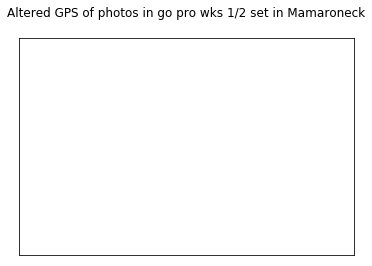

In [75]:
plt.figure(1)
plotgps(obj_photos_gps,col1='new_lat',col2='new_lon',color='lightblue',markeredgecolor='black',county="Smithtown")
plotgps(obj_photos_gps,col1='obj_lat',col2='obj_lon',color='sienna',county="Smithtown")

In [72]:
def convert_degrees(d,m,s):
    dec = d + m/60 + s/3600
    return dec


convert_degrees(73,11,23.66)


73.18990555555555

## COMPARE VALIDATE ANNOTATED VS. FOUND

In [109]:
all_annos = pd.read_csv('/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/allbboxes_wks123_go_mavic.csv',index_col=[0])
#all_annos

In [85]:
#chooses only the items in the val_keys set
#valid_annos = all_annos[all_annos['valid']]
#train_annos = all_annos[all_annos['train']]
#test_annos = all_annos[all_annos['test']]

In [110]:
#removing .jpgs from the photo names
#pd1.to_csv('~/Downloads/hackthesystem.csv')
#new_pd1 = pd.read_csv('~/Downloads/hackthesystem.csv',index_col=[0])
all_objs = all_annos.join(pd1,how='left')
len(all_objs)

1925

In [111]:
all_objs

,index,class instances,xmid,ymid,xmin,ymin,xmax,ymax,iwidth,iheight,...,test,lat,lon,date_taken,heading,length,width,alt,new_lat,new_lon
DJI_0001_18,1155,1,414.0,125.0,387.0,100.0,441.0,150.0,512.0,512.0,...,True,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967170,-73.732236
DJI_0001_23,387,1,78.5,244.0,59.0,228.0,98.0,260.0,416.0,512.0,...,True,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967170,-73.732565
DJI_0001_23,388,2,37.5,250.0,13.0,230.0,62.0,270.0,416.0,512.0,...,True,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967170,-73.732565
DJI_0001_23,389,3,226.5,235.0,188.0,222.0,265.0,248.0,416.0,512.0,...,True,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967170,-73.732565
DJI_0001_23,390,4,170.0,236.0,137.0,220.0,203.0,252.0,416.0,512.0,...,True,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967170,-73.732565
DJI_0001_25,532,1,447.0,405.0,440.0,397.0,454.0,413.0,512.0,512.0,...,False,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127
DJI_0001_25,533,2,381.5,427.0,369.0,415.0,394.0,439.0,512.0,512.0,...,False,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.967057,-73.732127
DJI_0001_34,1559,1,142.0,477.5,102.0,443.0,182.0,512.0,512.0,512.0,...,False,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.966944,-73.732236
DJI_0001_42,769,1,473.0,269.0,448.0,242.0,498.0,296.0,512.0,440.0,...,False,40.967057,-73.732455,2017:08:04 12:37:06,272.0,3000,4000,43.400,40.966830,-73.732236
DJI_0003_0,1635,1,128.0,272.0,74.0,231.0,182.0,313.0,512.0,512.0,...,False,40.967058,-73.732629,2017:08:04 12:37:23,271.5,3000,4000,43.700,40.967398,-73.732187


In [93]:
#converts cooords in valid_annos into GPS locations
valid_annos = all_objs[all_objs['valid']]
train_annos = all_objs[all_objs['train']]
test_annos = all_objs[all_objs['test']]

In [99]:
all_objs_gs = px2gps(all_objs.sort_values(by='photos'))


KeyError: 'photos'

In [96]:
valid_annos = all_objs_gs[all_objs_gs['valid']]
train_annos = all_objs_gs[all_objs_gs['train']]
test_annos = all_objs_gs[all_objs_gs['test']]

NameError: name 'all_objs_gs' is not defined

## Plots

In [871]:
print(plt.style.available)
plt.style.use('seaborn')

[u'seaborn-darkgrid', u'Solarize_Light2', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'fast', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']


In [881]:
col1='new_lat'
col2='new_lon'
print(new_pd1[col2].min()-.0005,new_pd1[col2].max()+.0005)
print(new_pd1[col1].min()-.0005, new_pd1[col1].max()+.0005)


(-73.736369179999997, -73.731005530000004)
(40.964088910000001, 40.968400080000002)


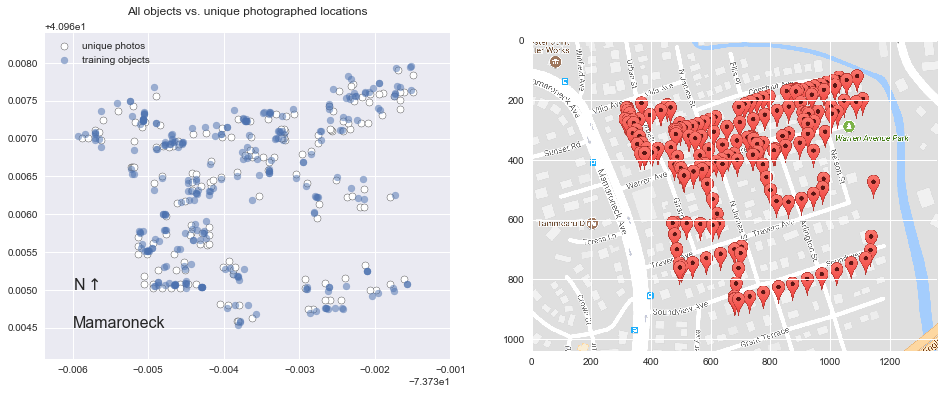

In [887]:
#all objects vs. unique photos

plt.figure(1,figsize = (16,6))
plt.subplot(1,2,1)

col1='new_lat'
col2='new_lon'
plt.scatter(new_pd1[col2],new_pd1[col1],facecolor='white',edgecolors='black')

plt.xlim(new_pd1[col2].min()-.0005, new_pd1[col2].max()+.0005)
plt.ylim(new_pd1[col1].min()-.0005, new_pd1[col1].max()+.0005)

col1='obj_lat'
col2='obj_lon'
plt.scatter(all_objs_gs[col2],all_objs_gs[col1],alpha=.5)

plt.legend(labels=['unique photos','training objects'])
plt.gca().invert_xaxis

plt.text(-73.736, 40.965,r'N$\uparrow$',fontsize=16)
plt.text(-73.736, 40.9645,r'Mamaroneck',fontsize=16)
plt.title('All objects vs. unique photographed locations\n')

plt.subplot(1,2,2)
mm = plt.imread('/Users/elizabeth/Desktop/Mamaroneck.png')
plt.imshow(mm)

Text(0.5,1,u'Validation objects vs. NN ID\n')

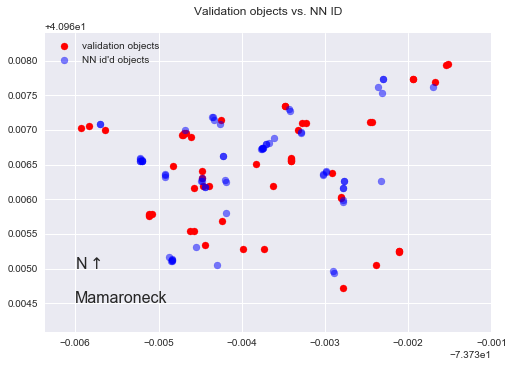

In [885]:
#all objects vs. unique photos

plt.figure(1)

col1='obj_lat'
col2='obj_lon'

plt.scatter(valid_objs_gps[col2],valid_objs_gps[col1],facecolor='red')

plt.xlim(-73.736369179999997, -73.731005530000004)
plt.ylim(40.964088910000001, 40.968400080000002)

plt.scatter(headings_w_nn[col2],headings_w_nn[col1],alpha=.5,facecolor='blue')

plt.legend(labels=['validation objects','NN id\'d objects'])
plt.gca().invert_xaxis

plt.text(-73.736, 40.965,r'N$\uparrow$',fontsize=16)
plt.text(-73.736, 40.9645,r'Mamaroneck',fontsize=16)
plt.title('Validation objects vs. NN ID\n')


In [888]:
print(len(valid_objs_gps), len(headings_w_nn))


(52, 68)


## CHANGE LAT/LON IN EXIF

In [157]:
path_to_open = '/Users/elizabeth/Box Sync/deeplearningcourse/elizabeth/data/harrison_fieldwork1/images_wks1_2/testingexif/'
path_to_save = '/Users/elizabeth/Box Sync/deeplearningcourse/elizabeth/data/harrison_fieldwork1/images_wks1_2/testingexif/'
img = 'G0036562_4.JPG'

f = open(path_to_open+img, 'rb')

# Return Exif tags
exif_dict = piexif.load

#convert to decimal
lat = tags['GPS GPSLatitude'].values
lon = tags['GPS GPSLongitude'].values

lat = [float(i.num/i.den) for i in lat]
lon = [float(i.num/i.den) for i in lon]

lat = lat[0] + (lat[1])/60 + lat[2]/3600
lon = lon[0] + (lon[1])/60 + lon[2]/3600

#splices crop slice number from file name
c = int(re.sub("[^0-9]","",img[-6:]))

#longitude
#for i in range(stepw)

if c==stepw*0 | c==stepw*1 | c==stepw*2 | c==stepw*3:# | stepw*4 | stepw*5:
    new_lon = lon - (stepw/2-0.5)*del_lon
    print('new lon=',new_lon)

elif c==(stepw*0+1) | c==stepw*1+1 | c==stepw*2+1 | c==stepw*3+1:#| stepw*4+1 | stepw*5+1:
    new_lon = lon - (stepw/2-1.5)*del_lon
    print('new lon=',new_lon)
    
elif c==stepw*0+2 | c==stepw*1+2 | c==stepw*2+2 | c==stepw*3+2:
    new_lon = lon - (stepw/2-2.5)*del_lon
    print('new lon=',new_lon)
    
elif c in [stepw*0+3,stepw*1+3,stepw*2+3,c==stepw*3+3]:
    new_lon = lon + (stepw/2-2.5)*del_lon
    print('new lon=',new_lon)
    
elif c in [stepw*0+4,stepw*1+4,stepw*2+4,c==stepw*3+4]:
    new_lon = lon + (stepw/2-1.5)*del_lon
    print('new lon=',new_lon)
    
elif c in [stepw*0+5,stepw*1+5,stepw*2+5,c==stepw*3+5]:
    new_lon = lon + (stepw/2-.5)*del_lon
    print('new lon=',new_lon)
    
else:
    print('lon num not defined', c)
    new_lon=lon

#latitude
if c in range(0,1*stepw):
    new_lat = lat + (steph/2-0.5)*lat_step
    print('new lat=',new_lat)
    
elif c in range(1*stepw,2*stepw):
    new_lat = lat + (steph/2-1.5)*lat_step
    print('new lat=',new_lat)
    
elif c in range(2*stepw,3*stepw):
    new_lat = lat + (steph/2-1.5)*lat_step
    print('new lat=',new_lat)
    
elif c in range(3*stepw,4*stepw):
    new_lat = lat + (steph/2-0.5)*lat_step
    print('new lat=',new_lat)
    
else:
    print('lat num not defined', c)
    new_lat=lat

print('new_lat = ', new_lat, "old lat =", lat)
print('new_lon = ',new_lon, "old lon =", lon)

('new lon=', 73.734519917327106)
('new lat=', 40.9670199173271)
('new_lat = ', 40.9670199173271, 'old lat =', 40.966944444444444)
('new_lon = ', 73.734519917327106, 'old lon =', 73.73444444444445)


In [128]:
px500 = 5.6 #m

lat_step = 5.6*lat_per_m # whatever step sizes you're taking (250px to centerline since photos are 500x500)
lon_step = 5.6*lon_per_m

#heading -- 0 for north, 90 if photo is turned east, etc; heading from north
theta = 0

#rotaion matrix [x';y'] = [cos -sin; sin cos][x;y]
del_lon= lat_step*np.cos(theta) - lon_step*np.sin(theta) 
del_lat = lat_step*np.sin(theta) +lon_step*np.cos(theta)

w = 3000
h = 2000
crop = 500

stepw = len(range(0,w,crop))
steph = len(range(0,h,crop))

def change_GPS_exif(dict_of_files,path_to_open,path_to_save)
      
    photo_info = {key:[0,0,0] for key in pd.keys()} #lat, lon

    files = [key for key in dict_of_files.keys()]

    for j in files :

        f = open(path_to_open+j, 'rb')

        # Return Exif tags
        exif_dict = piexif.load

        lat = dms2dec(tags['GPS GPSLatitude'].values)
        lon = dms2dec(tags['GPS GPSLongitude'].values)
        
        #longitude
        if c==stepw*0 | c==stepw*1 | c==stepw*2 | c==stepw*3:# | stepw*4 | stepw*5:
            new_lon = lon - (stepw/2-0.5)*del_lon

        elif c==stepw*0+1 | c==stepw*1+1 | c==stepw*2+1 | c==stepw*3+1:#| stepw*4+1 | stepw*5+1:
            new_lon = lon - (stepw/2-1.5)*del_lon

        elif c==stepw*0+2 | c==stepw*1+2 | c==stepw*2+2 | c==stepw*3+2:
            new_lon = lon - (stepw/2-2.5)*del_lon

        elif c==stepw*0+3 | c==stepw*1+3 | c==stepw*2+3 | c==stepw*3+3:
            new_lon = lon + (stepw/2-2.5)*del_lon

        elif c==stepw*0+4 | c==stepw*1+4 | c==stepw*2+4 | c==stepw*3+4:
            new_lon = lon + (stepw/2-1.5)*del_lon

        elif c==stepw*0+5 | c==stepw*1+5 | c==stepw*2+5 | c==stepw*3+5:
            new_lon = lon + (stepw/2-.5)*del_lon
        else:
            print('lon num not defined')
            new_lon=lon
        
        #latitude
        if c in range(0,1*stepw):
            new_lat = lat + (steph/2-0.5)*lat_step
        elif c in range(1*stepw,2*stepw):
            new_lat = lat + (steph/2-1.5)*lat_step
        elif c in range(2*stepw,3*stepw):
            new_lat = lat + (steph/2-1.5)*lat_step
        elif c in range(3*stepw,4*stepw):
            new_lat = lat + (steph/2-0.5)*lat_step
        else:
            print('lat num not defined' )
            new_lat=lat
        
        exif_dict['GPS'][2] = new_lat
        exif_dict['GPS'][4] = new_lon
        
        exif_bytes = piexif.dump(exifdict)
        im = Image.open(f)
        im.save(path_to_save+f, exif=exif_bytes)
        
        return lat,lon,new_lat,new_lon 
    

SyntaxError: invalid syntax (<ipython-input-128-1a373f807d39>, line 23)

In [733]:
bounding_boxes = {}
image_name = 'test'
class_name = 'box'
n = 5
ymin = 2
xmin = 3
bounding_box = [class_name,n,xmin,ymin]
bounding_boxes[image_name]=bounding_box
bounding_boxes['test'][1]

5

In [735]:
filenames = [1,2,3,4]
bounding_boxes = pd.DataFrame(index=filenames)

In [736]:
bounding_boxes.loc

""
1
2
3
4
